In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

/Users/vibhav/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#gdax = quandl.get('GDAX/USD', returns='pandas')

#kraken = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
#kraken["Weighted Price"][:1032]

#gdax["WP"] = (gdax["Open"][0] + gdax["High"][0] + gdax["Low"][0])/3

data.head()


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [3]:
#for i in range(0,1032):
    #gdax["WP"][i] = (gdax["Open"][i] + gdax["High"][i] + gdax["Low"][i])/3
    

In [4]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
#reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
#taking weighted volume and volumeC and next days weighted to predict 

values = reframed.values
n_train_hours = int(len(values) * 0.75)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
look_back = 1

# reshape input to be 3D [samples, timesteps, features]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
predictDates = data.tail(len(testX)).index

1115
371


In [5]:
model = Sequential()
model.add(LSTM(300,dropout=0 ,return_state=False,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(64, activation='linear'))
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 1116 samples, validate on 372 samples
Epoch 1/300
1116/1116 [==============================] - 1s 844us/step - loss: 0.0121 - val_loss: 0.2230
Epoch 2/300
1116/1116 [==============================] - 0s 71us/step - loss: 0.0101 - val_loss: 0.2020
Epoch 3/300
1116/1116 [==============================] - 0s 73us/step - loss: 0.0086 - val_loss: 0.1928
Epoch 4/300
1116/1116 [==============================] - 0s 79us/step - loss: 0.0077 - val_loss: 0.1773
Epoch 5/300
1116/1116 [==============================] - 0s 71us/step - loss: 0.0085 - val_loss: 0.1661
Epoch 6/300
1116/1116 [==============================] - 0s 74us/step - loss: 0.0073 - val_loss: 0.1578
Epoch 7/300
1116/1116 [==============================] - 0s 82us/step - loss: 0.0075 - val_loss: 0.1493
Epoch 8/300
1116/1116 [==============================] - 0s 80us/step - loss: 0.0069 - val_loss: 0.1397
Epoch 9/300
1116/1116 [==============================] - 0s 79us/step - loss: 0.0073 - val_loss: 0.1336
Epoch 10/300
111

1116/1116 [==============================] - 0s 66us/step - loss: 0.0030 - val_loss: 0.0127
Epoch 79/300
1116/1116 [==============================] - 0s 65us/step - loss: 0.0027 - val_loss: 0.0148
Epoch 80/300
1116/1116 [==============================] - 0s 71us/step - loss: 0.0021 - val_loss: 0.0302
Epoch 81/300
1116/1116 [==============================] - 0s 71us/step - loss: 0.0031 - val_loss: 0.0368
Epoch 82/300
1116/1116 [==============================] - 0s 70us/step - loss: 0.0027 - val_loss: 0.0209
Epoch 83/300
1116/1116 [==============================] - 0s 72us/step - loss: 0.0012 - val_loss: 0.0125
Epoch 84/300
1116/1116 [==============================] - 0s 68us/step - loss: 0.0042 - val_loss: 0.0210
Epoch 85/300
1116/1116 [==============================] - 0s 69us/step - loss: 0.0024 - val_loss: 0.0143
Epoch 86/300
1116/1116 [==============================] - 0s 72us/step - loss: 0.0015 - val_loss: 0.0309
Epoch 87/300
1116/1116 [==============================] - 0s 76us/st

1116/1116 [==============================] - 0s 84us/step - loss: 0.0022 - val_loss: 0.0145
Epoch 156/300
1116/1116 [==============================] - 0s 72us/step - loss: 0.0031 - val_loss: 0.0167
Epoch 157/300
1116/1116 [==============================] - 0s 69us/step - loss: 0.0018 - val_loss: 0.0152
Epoch 158/300
1116/1116 [==============================] - 0s 69us/step - loss: 0.0011 - val_loss: 0.0329
Epoch 159/300
1116/1116 [==============================] - 0s 68us/step - loss: 0.0021 - val_loss: 0.0383
Epoch 160/300
1116/1116 [==============================] - 0s 68us/step - loss: 0.0032 - val_loss: 0.0263
Epoch 161/300
1116/1116 [==============================] - 0s 71us/step - loss: 0.0038 - val_loss: 0.0147
Epoch 162/300
1116/1116 [==============================] - 0s 69us/step - loss: 0.0018 - val_loss: 0.0130
Epoch 163/300
1116/1116 [==============================] - 0s 68us/step - loss: 0.0010 - val_loss: 0.0269
Epoch 164/300
1116/1116 [==============================] - 0

1116/1116 [==============================] - 0s 72us/step - loss: 0.0012 - val_loss: 0.0249
Epoch 233/300
1116/1116 [==============================] - 0s 70us/step - loss: 0.0031 - val_loss: 0.0247
Epoch 234/300
1116/1116 [==============================] - 0s 69us/step - loss: 0.0018 - val_loss: 0.0124
Epoch 235/300
1116/1116 [==============================] - 0s 72us/step - loss: 0.0033 - val_loss: 0.0235
Epoch 236/300
1116/1116 [==============================] - 0s 69us/step - loss: 0.0018 - val_loss: 0.0113
Epoch 237/300
1116/1116 [==============================] - 0s 70us/step - loss: 0.0010 - val_loss: 0.0249
Epoch 238/300
1116/1116 [==============================] - 0s 67us/step - loss: 0.0022 - val_loss: 0.0326
Epoch 239/300
1116/1116 [==============================] - 0s 71us/step - loss: 0.0029 - val_loss: 0.0184
Epoch 240/300
1116/1116 [==============================] - 0s 72us/step - loss: 0.0029 - val_loss: 0.0164
Epoch 241/300
1116/1116 [==============================] - 0

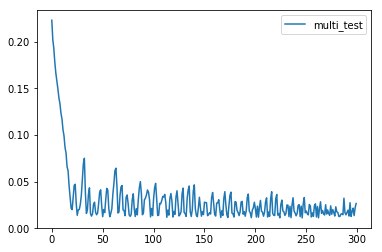

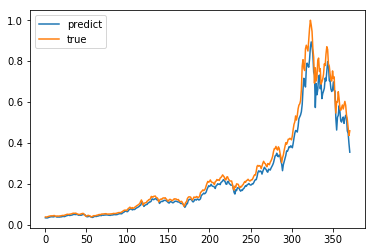

In [6]:

pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()
yhat = model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()



In [7]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 789.083


In [8]:

actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
py.iplot([ multi_predict_chart, actual_chart])

In [9]:
#from keras.models import load_model

#model.save('166RMSE_model.h5')  # creates a HDF5 file 'my_model.h5'

#model = load_model('my_model.h5')